In [53]:
#importing some models. Going to use tensorflow for modelling
#nltk contains list of stopwords to remove
#also import seaborn for plotting

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import nltk
import re



from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential


plt.style.use('dark_background')

In [54]:
#defining some variables, making it easier to tune them later

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [55]:
#import datasets. Also make seperate datasets for disaster and no disaster for EDA

df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')


disaster=df_train[df_train['target']==1]
nodisaster=df_train[df_train['target']==0]
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [56]:
#look how many empty columns we have
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17916\3472972775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster['word_count'] = disaster['text'].apply(lambda x: len(str(x).split()))
C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17916\3472972775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodisaster['word_count'] = nodisaster['text'].apply(lambda x: len(str(x).split()))
C:\Users\lrozebo1\AppData\Local\Temp\ipykernel_17916\3472972775.py:8: SettingWithCopyWarning: 
A value is trying to be

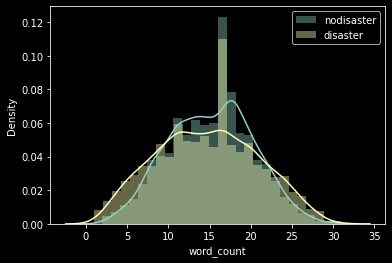

In [57]:
#plot number of words in text sequence



disaster['word_count'] = disaster['text'].apply(lambda x: len(str(x).split()))
nodisaster['word_count'] = nodisaster['text'].apply(lambda x: len(str(x).split()))

disaster['word_count'] = disaster['text'].apply(lambda x: len(str(x).split()))
nodisaster['word_count'] = nodisaster['text'].apply(lambda x: len(str(x).split()))


fig1,ax1=plt.subplots()
sns.distplot(disaster['word_count'],label='nodisaster')
sns.distplot(nodisaster['word_count'],label='disaster')
plt.legend()
plt.show()

In [58]:
#count number of disasters and nodisasters in training set
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [59]:
#look at different keywords
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [60]:
#put everything to lower case, remove hashtags from tweets

df_train['text_clean'] = df_train['text'].apply(lambda x: x.lower())
df_train['text_clean'] = df_train['text_clean'].str.replace('#','')
df_train['text_clean'].head(20)

0     our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask. canada
2     all residents asked to 'shelter in place' are ...
3     13,000 people receive wildfires evacuation ord...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update => california hwy. 20 closed ...
6     flood disaster heavy rain causes flash floodin...
7     i'm on top of the hill and i can see a fire in...
8     there's an emergency evacuation happening now ...
9     i'm afraid that the tornado is coming to our a...
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah- wait ...
12    raining flooding florida tampabay tampa 18 or ...
13                flood in bago myanmar we arrived bago
14    damage to school bus on 80 in multi car crash ...
15                                       what's up man?
16                                        i love fruits
17                                     summer is

In [61]:
#remove urls from tweets
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df_train['text_clean']=df_train['text_clean'].apply(lambda x: remove_url(x))
df_train.head(40)

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update => california hwy. 20 closed ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,i'm on top of the hill and i can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there's an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,i'm afraid that the tornado is coming to our a...


In [62]:
#train/validation split

xtrain, xval, ytrain, yval=train_test_split(df_train['text_clean'],df_train['target'])


#remove stopwords from train set, this will make these words out of vocabulary
#create list of stopwords to remove

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

xtrain = [' '.join([y for y in x.split() if y not in stop_words]) for x in xtrain]
xtrain

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lrozebo1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['@holymileyray @mooniighthunty focus going obliterate careers tea',
 'hear @drfriedencdc talk avoid thousands resistant infections/deaths next 5 yrs: adiossuperbacterias',
 "@emmerdale i'll devastated cain...such great character ??",
 'udhampur terror attack: militants attack police post 2 spos injured: suspected militants tonight attacked p...',
 '73rd goode water ski national championships go planned next week (event w/ damage tornado mon)',
 '@author_mike amen today day salvation. thx brother mike great encouragement. - coming us tsunami',
 "can't watch 'home alone 2' without telling kids 'she used casualty'. homealone2 film4",
 'homes razed northern calif. wildfire sandiego',
 'black eye 9: space battle occurred star o784 involving 2 fleets totaling 3939 ships 11 destroyed',
 'omg nixon lives! richard m. nixon tricky dicky right picture it. hiding calgary he...',
 'storm came where. .fuck cool',
 '@teafrystlik -- causing entire sky around battle darken violent storm ungodly powerf

In [63]:
#create tokenizer object and fit on text
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)


tokenizer.fit_on_texts(xtrain)
wordcounts=tokenizer.word_counts



#word count to dataframe
df=pd.DataFrame(wordcounts.values(),index=wordcounts.keys())

for i in stop_words:
    for j in df.index:
        if i == j:
            df.drop(i, inplace=True)

In [64]:
#df.plot()

In [65]:
#ceate sequences and pad sequences
train_seq=tokenizer.texts_to_sequences(xtrain)
train_padded=pad_sequences(train_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_seq=tokenizer.texts_to_sequences(xval)
val_padded=pad_sequences(val_seq,maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [66]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [68]:
num_epochs = 10
history = model.fit(train_padded, ytrain, epochs=num_epochs, validation_data=(val_padded, yval), verbose=2)

Epoch 1/10
179/179 - 2s - loss: 0.6846 - accuracy: 0.5661 - val_loss: 0.6839 - val_accuracy: 0.5599 - 2s/epoch - 11ms/step
Epoch 2/10
179/179 - 1s - loss: 0.6758 - accuracy: 0.5738 - val_loss: 0.6759 - val_accuracy: 0.5599 - 769ms/epoch - 4ms/step
Epoch 3/10
179/179 - 1s - loss: 0.6505 - accuracy: 0.5959 - val_loss: 0.6319 - val_accuracy: 0.6318 - 794ms/epoch - 4ms/step
Epoch 4/10
179/179 - 1s - loss: 0.5507 - accuracy: 0.7676 - val_loss: 0.5398 - val_accuracy: 0.7400 - 1s/epoch - 6ms/step
Epoch 5/10
179/179 - 1s - loss: 0.4232 - accuracy: 0.8474 - val_loss: 0.4734 - val_accuracy: 0.7915 - 1s/epoch - 6ms/step
Epoch 6/10
179/179 - 1s - loss: 0.3442 - accuracy: 0.8751 - val_loss: 0.4617 - val_accuracy: 0.7920 - 1s/epoch - 6ms/step
Epoch 7/10
179/179 - 1s - loss: 0.2963 - accuracy: 0.8896 - val_loss: 0.4700 - val_accuracy: 0.7899 - 707ms/epoch - 4ms/step
Epoch 8/10
179/179 - 1s - loss: 0.2643 - accuracy: 0.8981 - val_loss: 0.5083 - val_accuracy: 0.7647 - 817ms/epoch - 5ms/step
Epoch 9/10


In [69]:
#now apply the moddel to predict wether a sentence is about a disaster


df_test['text_clean'] = df_test['text'].apply(lambda x: x.lower())
df_test['text_clean'] = df_test['text_clean'].str.replace('#','')

df_test['text_clean']=df_test['text_clean'].apply(lambda x: remove_url(x))


sentences=df_test['text_clean']

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions=model.predict(padded)

In [70]:
df_test['prob_disaster']=predictions

df_test['target']=df_test['prob_disaster'].apply(lambda x: 1 if x>0.5 else 0)

df_output=df_test[['id','target']]

In [71]:
df_output.to_csv('output.csv',index=False)

In [72]:
testsentence=['This concert was the bomb']
testsequence=tokenizer.texts_to_sequences(testsentence)
paddedtestsequence=pad_sequences(testsequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
prob=model.predict(paddedtestsequence)
prob

array([[0.74611837]], dtype=float32)